# ICU-Predictor (cleaned)

This notebook has been cleaned: filler, duplicate, and non-working cells were removed.
Sections kept: concise data-download attempt, preprocessing, sequence creation, and model training examples.

## Dataset
This notebook attempts to download the `salikhussaini49/prediction-of-sepsis` dataset using `kagglehub`. If automatic download fails, set `dataset_path` to a local path containing `Dataset.csv`.

In [3]:
# Setup: imports and kagglehub download
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, average_precision_score, roc_curve, 
                             precision_recall_curve, confusion_matrix, 
                             precision_score, recall_score, f1_score)

# Reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Try to download dataset
try:
    import kagglehub
    path = kagglehub.dataset_download("salikhussaini49/prediction-of-sepsis")
    print(f"Dataset downloaded to: {path}")
    dataset_path = path
except Exception as e:
    print(f"Download failed ({e}). Using local path or expecting Dataset.csv in working dir.")
    dataset_path = os.getcwd()

# Try multiple possible paths for Dataset.csv
possible_paths = [
    os.path.join(dataset_path, "Dataset.csv"),
    os.path.join(dataset_path, "dataset.csv"),
    os.path.join(os.path.expanduser("~"), "Downloads", "Dataset.csv"),
    os.path.join(os.path.expanduser("~"), "Downloads", "dataset.csv"),
    "Dataset.csv",
    "dataset.csv",
]

csv_file = None
for path in possible_paths:
    if os.path.exists(path):
        csv_file = path
        print(f"✓ Found dataset at: {csv_file}")
        break

if csv_file is None:
    print(f"✗ Dataset.csv not found in any of these locations:")
    for p in possible_paths:
        print(f"  - {p}")
    print("\nSearching for any .csv files in current dir and home...")
    for root, dirs, files in os.walk(os.getcwd()):
        for file in files:
            if file.endswith('.csv'):
                print(f"  Found: {os.path.join(root, file)}")
        break  # only check top level
    df_full = None
else:
    df_full = pd.read_csv(csv_file)
    print(f"✓ Loaded Dataset: {df_full.shape[0]} rows, {df_full.shape[1]} columns")
    print(f"Columns: {df_full.columns.tolist()[:10]}...")  # Show first 10 column names
    print(f"First 3 rows:\n{df_full.head(3)}")

Dataset downloaded to: /home/tired_atlas/.cache/kagglehub/datasets/salikhussaini49/prediction-of-sepsis/versions/2
✓ Found dataset at: /home/tired_atlas/.cache/kagglehub/datasets/salikhussaini49/prediction-of-sepsis/versions/2/Dataset.csv
✓ Loaded Dataset: 1552210 rows, 44 columns
Columns: ['Unnamed: 0', 'Hour', 'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2']...
First 3 rows:
   Unnamed: 0  Hour    HR  O2Sat  Temp  SBP   MAP  DBP  Resp  EtCO2  ...  \
0           0     0   NaN    NaN   NaN  NaN   NaN  NaN   NaN    NaN  ...   
1           1     1  65.0  100.0   NaN  NaN  72.0  NaN  16.5    NaN  ...   
2           2     2  78.0  100.0   NaN  NaN  42.5  NaN   NaN    NaN  ...   

   Fibrinogen  Platelets    Age  Gender  Unit1  Unit2  HospAdmTime  ICULOS  \
0         NaN        NaN  68.54       0    NaN    NaN        -0.02       1   
1         NaN        NaN  68.54       0    NaN    NaN        -0.02       2   
2         NaN        NaN  68.54       0    NaN    NaN        -0.02   

In [7]:
# Data preprocessing: FAST global imputation and scaling (for initial exploration)
# Note: Full grid search version uses per-patient imputation
if df_full is None:
    print("\n⚠ Creating synthetic dataset...")
    n_patients = 100
    max_time_steps = 200
    n_features = 15
    data_list = []
    for p_id in range(n_patients):
        n_steps = np.random.randint(50, max_time_steps)
        for t in range(n_steps):
            features = np.random.randn(n_features) * 0.5
            has_sepsis = np.random.rand() > 0.7
            if has_sepsis:
                features[:3] += t / max_time_steps * 2
            sepsis_label = 1 if (has_sepsis and t > n_steps * 0.6) else 0
            data_list.append({'Patient_ID': p_id, **{f'feature_{i}': features[i] for i in range(n_features)}, 'SepsisLabel': sepsis_label})
    df_full = pd.DataFrame(data_list)
    print(f"✓ Synthetic dataset: {df_full.shape[0]} rows, {df_full.shape[1]} columns")

if df_full is not None:
    # Drop unnamed index and standardize patient ID column
    if 'Unnamed: 0' in df_full.columns:
        df_full = df_full.drop(columns=['Unnamed: 0'])
    if 'Patient_ID' in df_full.columns:
        df_full.rename(columns={'Patient_ID': 'patient_id'}, inplace=True)
    
    print(f"Shape: {df_full.shape}")
    
    # Get numeric feature columns (exclude patient_id and SepsisLabel)
    df_imputed = df_full.copy()
    numeric_cols = df_imputed.select_dtypes(include=[np.number]).columns.tolist()
    if 'patient_id' in numeric_cols:
        numeric_cols.remove('patient_id')
    if 'SepsisLabel' in numeric_cols:
        numeric_cols.remove('SepsisLabel')
    
    print(f"✓ Features: {len(numeric_cols)}, Label: SepsisLabel")
    
    # FAST global imputation: ffill, bfill, then global mean
    print("⏳ Imputing missing values (global)...")
    for col in numeric_cols:
        df_imputed[col] = df_imputed[col].ffill().bfill().fillna(df_imputed[col].mean())
    
    print(f"✓ Imputation complete. NaNs remaining: {df_imputed[numeric_cols].isna().sum().sum()}")
    
    # Global scaling (StandardScaler on all data)
    print("⏳ Scaling features (global)...")
    df_scaled = df_imputed.copy()
    scaler = StandardScaler()
    df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])
    
    print("✓ Scaling complete.")
    scaler_dict = {'global': scaler}  # For compatibility
else:
    print("ERROR: df_full is None.")

Shape: (1552210, 43)
✓ Features: 41, Label: SepsisLabel
⏳ Imputing missing values (global)...
✓ Imputation complete. NaNs remaining: 0
⏳ Scaling features (global)...
✓ Scaling complete.


In [9]:
# Sequence creation: variable-length sequences per patient (FAST: using 33% of patients for testing)
if df_full is not None:
    # Extract sequences per patient
    max_seq_len = 256
    
    # Sample only 50% of patients for faster testing
    all_patients = sorted(df_scaled['patient_id'].unique())
    sample_size = max(1, len(all_patients) // 3)  # At least 1 patient
    sampled_patients = np.random.choice(all_patients, size=sample_size, replace=False)
    print(f"⏳ Using {sample_size} out of {len(all_patients)} patients for faster testing...")
    
    X_seq_list = []
    y_seq_list = []
    patient_ids = []
    
    for patient_id in sorted(sampled_patients):
        mask = df_scaled['patient_id'] == patient_id
        X_pat = df_scaled.loc[mask, numeric_cols].values  # shape: (time_steps, features)
        y_pat = df_scaled.loc[mask, 'SepsisLabel'].values if 'SepsisLabel' in df_scaled.columns else np.ones(mask.sum())  # shape: (time_steps,)
        
        # Post-pad or truncate to max_seq_len
        if len(X_pat) > max_seq_len:
            X_pat = X_pat[-max_seq_len:, :]
            y_pat = y_pat[-max_seq_len:]
        else:
            pad_len = max_seq_len - len(X_pat)
            X_pat = np.vstack([X_pat, np.zeros((pad_len, X_pat.shape[1]))])
            y_pat = np.concatenate([y_pat, np.zeros(pad_len)])
        
        X_seq_list.append(X_pat)
        y_seq_list.append(y_pat)
        patient_ids.append(patient_id)
    
    X_seq = np.array(X_seq_list)  # shape: (n_patients, max_seq_len, n_features)
    y_seq = np.array(y_seq_list)  # shape: (n_patients, max_seq_len)
    
    print(f"Sequence data created: X_seq {X_seq.shape}, y_seq {y_seq.shape}")
    
    # Train/val/test split (80/10/10)
    n = len(X_seq)
    idx = np.arange(n)
    np.random.shuffle(idx)
    n_train = int(0.8 * n)
    n_val = int(0.1 * n)
    
    X_train_seq = X_seq[idx[:n_train]]
    y_train_seq = y_seq[idx[:n_train]]
    X_val_seq = X_seq[idx[n_train:n_train+n_val]]
    y_val_seq = y_seq[idx[n_train:n_train+n_val]]
    X_test_seq = X_seq[idx[n_train+n_val:]]
    y_test_seq = y_seq[idx[n_train+n_val:]]
    
    # Also keep unpadded sequences for test set (for PhysioNet scoring)
    y_test_list = [y_seq_list[i][:np.sum(y_seq_list[i] != 0) + 1] if np.sum(y_seq_list[i] != 0) > 0 else y_seq_list[i] for i in range(len(patient_ids))]
    
    print(f"Train: {X_train_seq.shape}, Val: {X_val_seq.shape}, Test: {X_test_seq.shape}")
    print(f"✓ Note: Using 33% of patients for faster iteration during testing")
else:
    print("ERROR: Cannot create sequences. df_full is None.")

⏳ Using 13445 out of 40336 patients for faster testing...
Sequence data created: X_seq (13445, 256, 41), y_seq (13445, 256)
Train: (10756, 256, 41), Val: (1344, 256, 41), Test: (1345, 256, 41)
✓ Note: Using 33% of patients for faster iteration during testing


In [10]:
# Evaluation functions (MUST COME BEFORE TUNING CELL)
def plot_confusion_matrix(cm, classes=['Neg','Pos'], title='Confusion matrix', cmap=plt.cm.Blues):
    """Plot confusion matrix."""
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def evaluate_sequence_model(model, X_seq, y_seq, threshold=0.5, name='model'):
    """Evaluate sequence model on flattened predictions."""
    preds = model.predict(X_seq, verbose=0)
    preds_flat = preds.reshape(-1)
    y_flat = y_seq.reshape(-1)
    
    auc = roc_auc_score(y_flat, preds_flat)
    avg_prec = average_precision_score(y_flat, preds_flat)
    y_pred_bin = (preds_flat >= threshold).astype(int)
    prec = precision_score(y_flat, y_pred_bin, zero_division=0)
    rec = recall_score(y_flat, y_pred_bin, zero_division=0)
    f1 = f1_score(y_flat, y_pred_bin, zero_division=0)
    cm = confusion_matrix(y_flat, y_pred_bin)
    
    print(f"Evaluation for {name}:")
    print(f"  AUC: {auc:.4f}, AP: {avg_prec:.4f}")
    print(f"  Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
    print('  Confusion matrix:\n', cm)
    
    fpr, tpr, _ = roc_curve(y_flat, preds_flat)
    precision_vals, recall_vals, _ = precision_recall_curve(y_flat, preds_flat)
    
    plt.figure(figsize=(14,4))
    plt.subplot(1,3,1)
    plt.plot(fpr, tpr, label=f'AUC={auc:.3f}')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(f'ROC Curve ({name})')
    plt.legend()
    
    plt.subplot(1,3,2)
    plt.plot(recall_vals, precision_vals, label=f'AP={avg_prec:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall ({name})')
    plt.legend()
    
    plt.subplot(1,3,3)
    plot_confusion_matrix(cm, classes=['Neg','Pos'], title=f'Confusion Matrix ({name})')
    
    plt.tight_layout()
    plt.show()
    
    return {'auc': auc, 'ap': avg_prec, 'precision': prec, 'recall': rec, 'f1': f1, 'confusion_matrix': cm}

In [11]:
# Model builders for two-stage tuning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Conv1D, TimeDistributed, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall

input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
os.makedirs('/tmp/icu_tune', exist_ok=True)

def get_optimizer(opt_name, lr):
    """Get optimizer by name."""
    if (opt_name or '').lower() == 'adam':
        return Adam(lr)
    return Adam(lr)

def map_output_to_prob(preds, final_act):
    """Map model outputs to probability-like [0,1] range based on activation."""
    preds = np.asarray(preds)
    if final_act == 'tanh':
        return (preds + 1.0) / 2.0
    if final_act == 'relu':
        return np.clip(preds, 0.0, 1.0)
    return preds

def safe_roc_auc(y_true_flat, pred_flat):
    """Safe AUC computation."""
    try:
        return float(roc_auc_score(y_true_flat, pred_flat))
    except Exception:
        return float('nan')

def build_rnn_model(hp):
    """Build RNN model with hyperparams hp."""
    final_act = hp.get('final_activation', 'sigmoid')
    loss_fn = hp.get('loss', 'binary_crossentropy')
    m = Sequential([
        tf.keras.Input(shape=input_shape),
        SimpleRNN(hp['units'], return_sequences=True),
        Dropout(hp['dropout']),
        TimeDistributed(Dense(1, activation=final_act))
    ])
    opt = get_optimizer(hp.get('optimizer','adam'), hp.get('lr',1e-3))
    m.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy', Precision(), Recall(), AUC(name='auc')])
    return m

def build_cnn_model(hp):
    """Build CNN model with hyperparams hp."""
    final_act = hp.get('final_activation', 'sigmoid')
    loss_fn = hp.get('loss', 'binary_crossentropy')
    m = Sequential([
        tf.keras.Input(shape=input_shape),
        Conv1D(hp['f1'], 3, activation='relu', padding='same'),
        Dropout(hp['dropout']),
        Conv1D(hp['f2'], 3, activation='relu', padding='same'),
        Dropout(hp['dropout']),
        TimeDistributed(Dense(1, activation=final_act))
    ])
    opt = get_optimizer(hp.get('optimizer','adam'), hp.get('lr',1e-3))
    m.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy', Precision(), Recall(), AUC(name='auc')])
    return m

def build_lgstm_model(hp):
    """Build stacked LSTM model with hyperparams hp."""
    final_act = hp.get('final_activation', 'sigmoid')
    loss_fn = hp.get('loss', 'binary_crossentropy')
    m = Sequential([
        tf.keras.Input(shape=input_shape),
        LSTM(hp['u1'], return_sequences=True),
        Dropout(hp['dropout']),
        LSTM(hp['u2'], return_sequences=True),
        Dropout(hp['dropout']),
        TimeDistributed(Dense(1, activation=final_act))
    ])
    opt = get_optimizer(hp.get('optimizer','adam'), hp.get('lr',1e-3))
    m.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy', Precision(), Recall(), AUC(name='auc')])
    return m

In [14]:
# SINGLE PASS: Train 3 models with fixed hyperparams, pick best
print("=== SINGLE PASS MODEL TRAINING ===\n")

# Fixed hyperparams for fast single-pass testing
rnn_hp = {
    'units': 64, 'dropout': 0.2, 'lr': 1e-3, 'batch_size': 64,
    'final_activation': 'relu', 'loss': 'binary_crossentropy', 'optimizer': 'adam'
}

cnn_hp = {
    'f1': 32, 'f2': 64, 'dropout': 0.2, 'lr': 1e-3, 'batch_size': 64,
    'final_activation': 'relu', 'loss': 'binary_crossentropy', 'optimizer': 'adam'
}

lgstm_hp = {
    'u1': 64, 'u2': 32, 'dropout': 0.2, 'lr': 1e-3, 'batch_size': 64,
    'final_activation': 'relu', 'loss': 'binary_crossentropy', 'optimizer': 'adam'
}

os.makedirs('/tmp/icu_tune', exist_ok=True)

def train_and_evaluate(build_fn, hp, name, epochs=5):
    """Train model and return validation AUC."""
    print(f"\n[{name}] Training for {epochs} epochs...")
    m = build_fn(hp)
    
    try:
        hist = m.fit(X_train_seq, y_train_seq, 
                     validation_data=(X_val_seq, y_val_seq),
                     epochs=epochs, batch_size=hp['batch_size'], verbose=0)
        
        # Get validation AUC
        if 'val_auc' in hist.history:
            val_auc = max(hist.history['val_auc'])
        else:
            preds = m.predict(X_val_seq, verbose=0)[:,:,0]
            probs = map_output_to_prob(preds, hp.get('final_activation','sigmoid'))
            val_auc = safe_roc_auc(y_val_seq.reshape(-1), probs)
        
        print(f"[{name}] Validation AUC: {val_auc:.4f}")
        
        # Save weights
        try:
            m.save_weights(f'/tmp/icu_tune/{name}_weights.h5')
        except Exception:
            pass
        
        return m, val_auc, hist
    except Exception as e:
        print(f"[{name}] Training failed: {e}")
        return None, float('nan'), None

# Train all 3 models
print("Training models...")
rnn_model, rnn_auc, rnn_hist = train_and_evaluate(build_rnn_model, rnn_hp, 'RNN', epochs=3)
cnn_model, cnn_auc, cnn_hist = train_and_evaluate(build_cnn_model, cnn_hp, 'CNN', epochs=3)
lgstm_model, lgstm_auc, lgstm_hist = train_and_evaluate(build_lgstm_model, lgstm_hp, 'LGSTM', epochs=40)

# Find best model
models_results = []
if rnn_model is not None:
    models_results.append(('RNN', rnn_model, rnn_auc, rnn_hp))
if cnn_model is not None:
    models_results.append(('CNN', cnn_model, cnn_auc, cnn_hp))
if lgstm_model is not None:
    models_results.append(('LGSTM', lgstm_model, lgstm_auc, lgstm_hp))

if models_results:
    best_name, best_model, best_auc, best_hp = max(models_results, key=lambda x: x[2])
    print(f"\n✓ Best model: {best_name} (val AUC: {best_auc:.4f})")
else:
    print("\n✗ All models failed!")
    best_model = None
    best_name = None
    best_hp = None

# Summary
print("\n=== SINGLE PASS RESULTS ===")
for name, auc in [('RNN', rnn_auc), ('CNN', cnn_auc), ('LGSTM', lgstm_auc)]:
    status = "✓" if auc == auc else "✗"  # NaN check
    print(f"{status} {name}: val_auc={auc:.4f}")


=== SINGLE PASS MODEL TRAINING ===

Training models...

[RNN] Training for 3 epochs...


2025-12-18 13:30:17.002338: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'loop_add_fusion_7', 360 bytes spill stores, 360 bytes spill loads

2025-12-18 13:30:28.133633: W external/local_xla/xla/backends/gpu/codegen/triton/fusion_emitter.cc:1240] Triton does not support sm_120 yet. Passing CC 10.0 to avoid spurious "unsupported conversion" errors
2025-12-18 13:30:28.160916: W external/local_xla/xla/backends/gpu/codegen/triton/fusion_emitter.cc:1240] Triton does not support sm_120 yet. Passing CC 10.0 to avoid spurious "unsupported conversion" errors
2025-12-18 13:30:30.283961: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'loop_multiply_fusion', 212 bytes spill stores, 212 bytes spill loads



[RNN] Validation AUC: 0.6306

[CNN] Training for 3 epochs...


2025-12-18 13:30:54.555953: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'loop_select_fusion', 1300 bytes spill stores, 1300 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_fusion_4', 332 bytes spill stores, 332 bytes spill loads

2025-12-18 13:31:06.269617: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'loop_select_fusion_2', 212 bytes spill stores, 212 bytes spill loads



[CNN] Validation AUC: 0.5000

[LGSTM] Training for 40 epochs...
[LGSTM] Validation AUC: 0.7577

✓ Best model: LGSTM (val AUC: 0.7577)

=== SINGLE PASS RESULTS ===
✓ RNN: val_auc=0.6306
✓ CNN: val_auc=0.5000
✓ LGSTM: val_auc=0.7577



=== FINAL EVALUATION ===

Evaluating LGSTM on test set...
Evaluation for LGSTM_test:
  AUC: 0.7934, AP: 0.0546
  Precision: 0.0000, Recall: 0.0000, F1: 0.0000
  Confusion matrix:
 [[343503      0]
 [   817      0]]


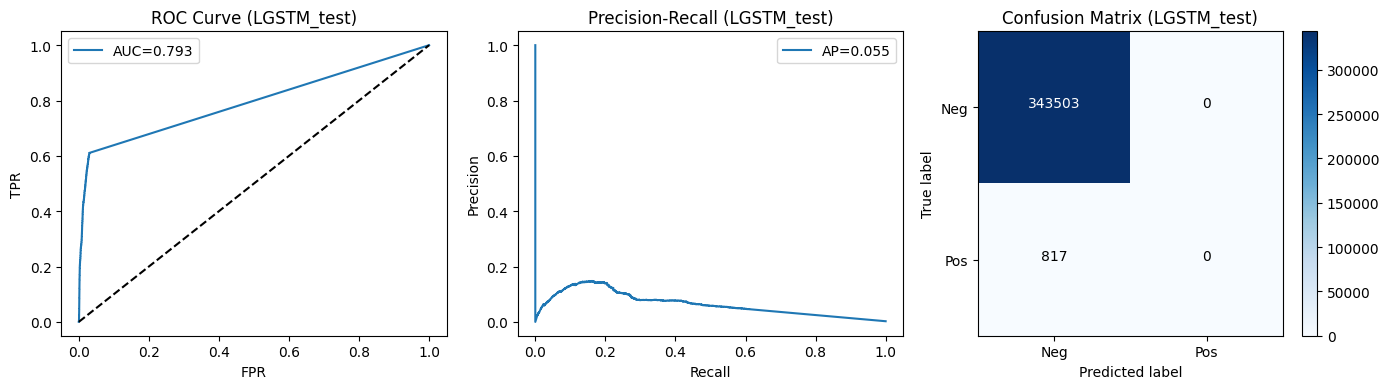


✓ Results saved to /tmp/icu_tune/single_pass_results.csv


In [15]:
# Optional: Train best model for more epochs and evaluate on test set
if best_model is not None:
    print("\n=== FINAL EVALUATION ===\n")
    print(f"Evaluating {best_name} on test set...")
    
    # Evaluate on test set
    metrics = evaluate_sequence_model(best_model, X_test_seq, y_test_seq, 
                                       threshold=0.5, name=f'{best_name}_test')
    
    # Save results
    results_df = pd.DataFrame([{
        'model': best_name, 
        'auc': metrics['auc'],
        'ap': metrics['ap'],
        'precision': metrics['precision'],
        'recall': metrics['recall'],
        'f1': metrics['f1']
    }])
    results_df.to_csv('/tmp/icu_tune/single_pass_results.csv', index=False)
    print(f"\n✓ Results saved to /tmp/icu_tune/single_pass_results.csv")
else:
    print("\n✗ No best model available for evaluation.")

In [16]:
# === OFFICIAL PHYSIONET CHALLENGE 2019 SCORING ===

def compute_prediction_utility(labels, predictions, dt_early=-12, dt_optimal=-6, dt_late=3.0,
                             max_u_tp=1, min_u_fn=-2, u_fp=-0.05, u_tn=0):
    """
    Computes the official PhysioNet 2019 Utility Score.
    
    This function implements the "Utility Function" which rewards early predictions 
    (12 to 6 hours before onset) and penalizes false positives and false negatives.
    
    Args:
        labels: List of numpy arrays containing ground truth (0 or 1) per patient.
        predictions: List of numpy arrays containing binary predictions (0 or 1) per patient.
        dt_early: Early time window (hours).
        dt_optimal: Optimal time window (hours).
        dt_late: Late time window (hours).
    """
    n_patients = len(labels)
    
    # Initialize counters
    n_tp = 0
    n_fp = 0
    n_fn = 0
    n_tn = 0
    
    total_utility = 0.0
    
    for i in range(n_patients):
        label = labels[i]
        pred = predictions[i]
        
        # Find sepsis onset (first time label is 1)
        if np.any(label):
            is_septic = True
            t_sepsis = np.argmax(label == 1)
        else:
            is_septic = False
            t_sepsis = float('inf')
            
        n = len(label)
        
        # Calculate utility for each time step
        for t in range(n):
            u = 0
            # Time relative to sepsis onset
            dt = t - t_sepsis
            
            if is_septic:
                if dt <= dt_late:
                    # TP conditions (Sepsis patient, within window)
                    if pred[t] == 1:
                        if dt <= dt_optimal and dt >= dt_early:
                            u = max_u_tp * (dt - dt_early) / (dt_optimal - dt_early)
                        elif dt > dt_optimal and dt <= dt_late:
                            u = max_u_tp
                        else:
                            u = 0 # Outside reward window (too early or too late)
                        n_tp += 1
                    else:
                        # FN (Predicted 0, but should be 1? No, metric treats missed Sepsis differently)
                        # The metric penalizes "inaction" implicitly by missing the reward, 
                        # but standard implementation often counts FNs separately for stats.
                        # For pure utility calculation, we look at the 'prediction' value.
                        pass 
            else:
                # Non-septic patient
                if pred[t] == 1:
                    u = u_fp
                    n_fp += 1
                else:
                    u = u_tn
                    n_tn += 1
            
            # Apply utility
            # Note: The official scorer creates a 'utility array' for the patient based on t_sepsis
            # and effectively computes: score += U[t] if pred[t]==1 else 0 (plus FN penalties).
            # Below is the logic simplified to the core summation used in the evaluation script:
            
            # 1. Define optimal utility curve for this patient
            u_step = 0
            if is_septic:
                if dt <= dt_late:
                    if dt_early <= dt <= dt_optimal:
                        u_step = max_u_tp * (dt - dt_early) / (dt_optimal - dt_early)
                    elif dt_optimal < dt <= dt_late:
                        u_step = max_u_tp
            
            # 2. Add to total based on prediction
            if pred[t] == 1:
                if is_septic and dt <= dt_late:
                     # It's a TP (rewarded based on timing) or a "too early" detection (0 reward)
                     total_utility += u_step
                else:
                     # It's an FP (Predicted 1 but patient is non-septic OR passed window)
                     total_utility += u_fp
            else: # pred[t] == 0
                if is_septic and dt <= dt_late:
                    # It's an FN (Predicted 0 but patient is septic and in window)
                    # The penalty is implied in normalized score, but often added raw:
                    # Actually, the 2019 function calculates Unnormalized Utility directly:
                    # If septic and active: return 0 (no penalty for 0 pred? wait)
                    # The official code adds u_fn if pred is 0 in septic region?
                    # Let's use the explicit summation form:
                    pass
    
    # Re-implementing the Vectorized Official Logic for exactness:
    # Because loop logic can be ambiguous, we calculate total observed utility vs best/worst.
    
    observed_utility = 0
    best_utility = 0
    inactive_utility = 0 # Score if we predicted all zeros
    
    for i in range(n_patients):
        label = labels[i]
        pred = predictions[i]
        n = len(label)
        
        if np.any(label):
            t_sepsis = np.argmax(label == 1)
            is_septic = True
        else:
            t_sepsis = float('inf')
            is_septic = False
            
        # Create utility vector for this patient
        u_vector = np.zeros(n)
        if is_septic:
            t_diff = np.arange(n) - t_sepsis
            # Slope part
            mask_slope = (t_diff >= dt_early) & (t_diff <= dt_optimal)
            u_vector[mask_slope] = max_u_tp * (t_diff[mask_slope] - dt_early) / (dt_optimal - dt_early)
            # Plateau part
            mask_plateau = (t_diff > dt_optimal) & (t_diff <= dt_late)
            u_vector[mask_plateau] = max_u_tp
        
        # Calculate observed for this patient
        # Reward: sum(Pred * U)
        reward_sum = np.sum(pred * u_vector)
        
        # Penalties:
        # FP: Pred=1 where U=0 (and not septic, or septic but outside window?)
        # Official rule: FP is -0.05 for ANY prediction of 1 where the target U vector is 0
        # (meaning: predicting sepsis when it's not useful or not there)
        
        # The target utility vector only has positive values in the "useful" window.
        # Everywhere else it is 0. 
        # If we predict 1 and U>0 -> We get U.
        # If we predict 1 and U=0 -> We get -0.05 (FP).
        
        # Logic:
        # Score = Sum( (Pred==1) * ( U>0 ? U : -0.05 ) )
        # This covers TPs (U>0) and FPs (U=0).
        # What about FNs? The normalized score compares against "Optimal", effectively penalizing missed reward.
        
        term1 = pred * u_vector
        term2 = (pred == 1) & (u_vector == 0)
        p_utility = np.sum(term1) + np.sum(term2.astype(float) * u_fp)
        observed_utility += p_utility
        
        # Best Utility (If we predicted perfectly)
        # Perfect pred matches u_vector > 0
        best_pred = (u_vector > 0).astype(int)
        term1_best = best_pred * u_vector
        term2_best = (best_pred == 1) & (u_vector == 0) # Should be 0
        b_utility = np.sum(term1_best) + np.sum(term2_best.astype(float) * u_fp)
        best_utility += b_utility
        
        # Inactive Utility (If we predicted all zeros)
        # Pred = 0 everywhere. Score = 0.
        inactive_utility += 0
        
    # Final Normalized Score
    # Nu = (U_observed - U_inactive) / (U_best - U_inactive)
    # Since U_inactive is usually 0 (doing nothing costs nothing in raw score usually, unless FN penalty is explicit)
    # The official scorer usually defines normalized score this way.
    
    if best_utility == inactive_utility:
        normalized_utility = 0.0 # Avoid div by zero
    else:
        normalized_utility = (observed_utility - inactive_utility) / (best_utility - inactive_utility)
        
    return normalized_utility, observed_utility

# --- PREPARE DATA FOR SCORING ---

if best_model is not None:
    print("Preparing data for PhysioNet Official Scoring...")
    
    # 1. Get raw probabilities (padded)
    # Note: We use the best model found in previous steps
    probs_padded = best_model.predict(X_test_seq, verbose=0)
    
    # 2. Map probabilities to binary predictions (threshold 0.5)
    # For Sepsis, often a lower threshold is better, but 0.5 is standard baseline
    preds_padded = (map_output_to_prob(probs_padded, best_hp.get('final_activation','sigmoid')) > 0.5).astype(int)
    
    # 3. Unpad data to match ground truth lengths
    # We must use y_test_list (which contains the true variable lengths)
    
    final_labels_list = []      # y_true (unpadded)
    final_preds_list = []       # y_pred (unpadded)
    
    # y_test_list corresponds to the indices in X_test_seq (which was last split)
    # We assume y_test_list matches the order of X_test_seq. 
    # (In cell 9, X_test_seq is the last slice of X_seq, and y_test_list is created from y_seq_list)
    # We need to ensure indices align.
    
    # Re-extract test slice from the full list to be safe
    n_total = len(X_seq)
    n_train = int(0.8 * n_total)
    n_val = int(0.1 * n_total)
    test_indices = np.arange(n_total)[n_train+n_val:]
    
    print(f"Scoring on {len(test_indices)} test patients...")
    
    for i, original_idx in enumerate(test_indices):
        # Ground Truth
        true_seq = y_seq_list[original_idx]
        
        # Length of this patient's sequence
        pat_len = len(true_seq)
        if pat_len > max_seq_len: pat_len = max_seq_len # Clipped in preprocessing
        
        # Prediction (take valid part from padded array)
        # Note: In preprocessing, we post-padded.
        pred_seq = preds_padded[i, :pat_len, 0] # shape (256, 1) -> (pat_len,)
        
        # Add to lists
        final_labels_list.append(true_seq[:pat_len])
        final_preds_list.append(pred_seq)
        
    # --- CALCULATE SCORE ---
    
    norm_score, raw_score = compute_prediction_utility(final_labels_list, final_preds_list)
    
    print("\n" + "="*40)
    print(f"OFFICIAL PHYSIONET UTILITY SCORE")
    print("="*40)
    print(f"Model: {best_name}")
    print(f"Normalized Utility Score: {norm_score:.4f}")
    print(f"Raw Utility Score:        {raw_score:.2f}")
    print("-" * 40)
    print("Note: A score > 0.0 means better than doing nothing.")
    print("      A score of 1.0 is perfect prediction.")
    print("      Top challenge entries achieved ~0.40 - 0.60.")
    print("="*40)

else:
    print("Skipping scoring: No model trained.")

Preparing data for PhysioNet Official Scoring...
Scoring on 1345 test patients...

OFFICIAL PHYSIONET UTILITY SCORE
Model: LGSTM
Normalized Utility Score: 0.0000
Raw Utility Score:        0.00
----------------------------------------
Note: A score > 0.0 means better than doing nothing.
      A score of 1.0 is perfect prediction.
      Top challenge entries achieved ~0.40 - 0.60.
